<a href="https://colab.research.google.com/github/faizanahemad/eva/blob/master/assignment-14/DN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Resources**

- XLA

    - [Google Notebook example](https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/compiler/xla/g3doc/tutorials/xla_compile.ipynb)

    - [Blog](https://medium.com/@xianbao.qian/use-xla-with-keras-3ca5d0309c26)
    - [Example Enabling XLA](https://github.com/tensorflow/models/blob/7212436440eaa11293ca84befcc5d8327109ea76/official/utils/misc/keras_utils.py#L158)
    
- Mixed Precision

- Augmentation Libs
    - [imgaug](https://github.com/aleju/imgaug)
    - [albumentations](https://github.com/albu/albumentations)
    - [Automold](https://github.com/UjjwalSaxena/Automold--Road-Augmentation-Library)
    - [Tensorflow Examples](https://www.wouterbulten.nl/blog/tech/data-augmentation-using-tensorflow-data-dataset/)
    - [PIL ImageOps Examples](https://hhsprings.bitbucket.io/docs/programming/examples/python/PIL/ImageOps.html)

# Imports

In [1]:
import os
import gc
BATCH_SIZE = 512 #@param {type:"integer"}
MOMENTUM = 0.9 #@param {type:"number"}
LEARNING_RATE = 0.5 #@param {type:"number"}
WEIGHT_DECAY = 1e-4 #@param {type:"number"}
EPOCHS = 13 #@param {type:"integer"}
cutout_proba = 0.25

jobs = int(os.cpu_count()/2)

float_rep = "float16"


In [2]:
def get_config_proto_v1():
    """Return config proto according to flag settings, or None to use default."""
    config = tf.compat.v1.ConfigProto()
    return config


import tensorflow as tf

# tf.keras.backend.set_epsilon(1e-4)
# tf.keras.backend.set_floatx('float16')


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ec2-user/a

In [3]:
import tensorflow as tf
tf.enable_eager_execution()
# tf.random.set_random_seed(1234)

In [4]:
from tensorflow.keras.backend import set_session
from tensorflow.keras.backend import clear_session
from tensorflow.keras.backend import get_session
import tensorflow
import tensorflow as tf

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    # config = tensorflow.ConfigProto(log_device_placement=True, allow_soft_placement=True,)
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tensorflow.Session(config=config))
    
# reset_keras()

In [5]:
import numpy as np
import skimage
print(np.__version__)
print(skimage.__version__)

import time, math
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.contrib.eager as tfe
import gc
print(tf.__version__)
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
% matplotlib inline
%config InlineBackend.figure_format='retina'

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from tensorflow.core.protobuf import rewriter_config_pb2
import os


import imgaug.augmenters as iaa
from matplotlib import cm
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,RandomFog,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, ChannelDropout, ChannelShuffle,RandomContrast
)

1.17.0
0.15.0
1.14.0


In [6]:

def get_cutout_eraser(p=0.5, s_l=0.045, s_h=0.065, r_1=0.35, r_2=1 / 0.35, 
                      v_l=-1,v_h=1,
                      max_erasures_per_image=1, pixel_level=True):
    """

    :param p:
    :param s_l: Minimum Area Proportion of Original that may be cut
    :param s_h: Maximum Area Proportion of Original that may be cut
    :param r_1: Min Aspect Ratio
    :param r_2: Max Aspect Ratio
    :param max_erasures_per_image:
    :param pixel_level:
    :return: Eraser to be used as Preprocessing Function
    """
    assert max_erasures_per_image >= 1

    def eraser(input_img, proba=p):
        p_1 = np.random.rand()
        if p_1 > proba:
            return input_img
        img_h, img_w, img_c = input_img.shape
        shape = input_img.shape
        
        v_l = np.min(input_img)
        v_h = np.max(input_img)
        
#         mx = np.random.randint(1, max_erasures_per_image + 1)
        mx = max_erasures_per_image
        for i in range(mx):
            while True:
                s = np.random.uniform(s_l, s_h) * img_h * img_w
                r = np.random.uniform(r_1, r_2)
                w = int(np.sqrt(s / r))
                h = int(np.sqrt(s * r))
                left = np.random.randint(0, img_w)
                top = np.random.randint(0, img_h)

                if left + w <= img_w and top + h <= img_h:
                    break

            if pixel_level:
                c = np.random.uniform(v_l, v_h, (h, w, img_c))
            else:
                c = np.random.uniform(v_l, v_h)

            input_img[top:top + h, left:left + w, :] = c
        
        return input_img

    return eraser




In [7]:
log = False



def log_fn_enabled(*args):
    print(*args)
    

def log_fn_disabled(*args):
    pass

log_fn = log_fn_enabled if log else log_fn_disabled

In [8]:
from tensorflow.keras.layers import BatchNormalization, Layer,InputSpec
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.initializers import Initializer
from tensorflow.python.keras.backend import _regular_normalize_batch_in_training


#custom initializers to force float32
class Ones32(Initializer):
    def __call__(self, shape, dtype=None):
        return K.constant(1, shape=shape, dtype='float32')

class Zeros32(Initializer):
    def __call__(self, shape, dtype=None):
        return K.constant(0, shape=shape, dtype='float32')
    


class BatchNormalizationF16(Layer):

    def __init__(self,
                 axis=-1,
                 momentum=0.99,
                 epsilon=1e-4,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 moving_mean_initializer='zeros',
                 moving_variance_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(BatchNormalizationF16, self).__init__(**kwargs)
        self.supports_masking = True
        self.axis = axis
        self.momentum = momentum
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.moving_mean_initializer = initializers.get(moving_mean_initializer)
        self.moving_variance_initializer = (
            initializers.get(moving_variance_initializer))
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        dim = input_shape[self.axis]
        if dim is None:
            raise ValueError('Axis ' + str(self.axis) + ' of '
                             'input tensor should have a defined dimension '
                             'but the layer received an input with shape ' +
                             str(input_shape) + '.')
        self.input_spec = InputSpec(ndim=len(input_shape),
                                    axes={self.axis: dim})
        shape = (dim,)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.moving_mean = self.add_weight(
            shape=shape,
            name='moving_mean',
            initializer=self.moving_mean_initializer,
            trainable=False)
        self.moving_variance = self.add_weight(
            shape=shape,
            name='moving_variance',
            initializer=self.moving_variance_initializer,
            trainable=False)
        self.built = True

    def call(self, inputs, training=None):
        input_shape = K.int_shape(inputs)
        # Prepare broadcasting shape.
        ndim = len(input_shape)
        reduction_axes = list(range(len(input_shape)))
        del reduction_axes[self.axis]
        broadcast_shape = [1] * len(input_shape)
        broadcast_shape[self.axis] = input_shape[self.axis]

        # Determines whether broadcasting is needed.
        needs_broadcasting = (sorted(reduction_axes) != list(range(ndim))[:-1])

        def normalize_inference():
            if needs_broadcasting:
                # In this case we must explicitly broadcast all parameters.
                broadcast_moving_mean = K.reshape(self.moving_mean,
                                                  broadcast_shape)
                broadcast_moving_variance = K.reshape(self.moving_variance,
                                                      broadcast_shape)
                if self.center:
                    broadcast_beta = K.reshape(self.beta, broadcast_shape)
                else:
                    broadcast_beta = None
                if self.scale:
                    broadcast_gamma = K.reshape(self.gamma,
                                                broadcast_shape)
                else:
                    broadcast_gamma = None
                return tf.nn.batch_normalization(#K.batch_normalization(
                    inputs,
                    broadcast_moving_mean,
                    broadcast_moving_variance,
                    broadcast_beta,
                    broadcast_gamma,
                    #axis=self.axis,
                    self.epsilon)#epsilon=self.epsilon)
            else:
                return tf.nn.batch_normalization(#K.batch_normalization(
                    inputs,
                    self.moving_mean,
                    self.moving_variance,
                    self.beta,
                    self.gamma,
                    #axis=self.axis,
                    self.epsilon)#epsilon=self.epsilon)

        # If the learning phase is *static* and set to inference:
        if training in {0, False}:
            return normalize_inference()

        # If the learning is either dynamic, or set to training:
        normed_training, mean, variance = _regular_normalize_batch_in_training(#K.normalize_batch_in_training(
            inputs, self.gamma, self.beta, reduction_axes,
            epsilon=self.epsilon)

        if K.backend() != 'cntk':
            sample_size = K.prod([K.shape(inputs)[axis]
                                  for axis in reduction_axes])
            sample_size = K.cast(sample_size, dtype=K.dtype(inputs))

            # sample variance - unbiased estimator of population variance
            variance *= sample_size / (sample_size - (1.0 + self.epsilon))

        self.add_update([K.moving_average_update(self.moving_mean,
                                                 mean,
                                                 self.momentum),
                         K.moving_average_update(self.moving_variance,
                                                 variance,
                                                 self.momentum)],
                        inputs)

        # Pick the normalized form corresponding to the training phase.
        return K.in_train_phase(normed_training,
                                normalize_inference,
                                training=training)

    def get_config(self):
        config = {
            'axis': self.axis,
            'momentum': self.momentum,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'moving_mean_initializer':
                initializers.serialize(self.moving_mean_initializer),
            'moving_variance_initializer':
                initializers.serialize(self.moving_variance_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(BatchNormalizationF16, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape
    
    


In [9]:

# BatchNorm = BatchNormalizationF16

BatchNorm = tf.keras.layers.BatchNormalization



In [10]:
from PIL import Image, ImageEnhance, ImageOps
import numpy as np
import random

class CIFAR10Policy(object):
    def __init__(self, fillcolor=(128, 128, 128), log=False):
        self.policies = [
            SubPolicy("rotate", fillcolor),
            SubPolicy("sharpness", fillcolor),
            SubPolicy("shearY", fillcolor),
            SubPolicy("shearX", fillcolor),
            SubPolicy("posterize", fillcolor),
            SubPolicy("color", fillcolor),
            SubPolicy("brightness", fillcolor),
            SubPolicy("contrast", fillcolor), 
        ]
        self.log = log


    def __call__(self, img, policy_idx=None, magnitude_idx=None):
        policy_idx = random.randint(0, len(self.policies) - 1) if policy_idx is None else policy_idx
        policy = self.policies[policy_idx]
        log_fn("Policy = ",policy_idx, policy.op1_name)
        return policy(img,magnitude_idx)


class SubPolicy(object):
    def __init__(self, operation1, fillcolor=(128, 128, 128)):
        self.ranges = {
            "shearX": np.linspace(0.1, 0.3, 10),
            "shearY": np.linspace(0.1, 0.3, 10),
            "rotate": np.linspace(10, 30, 10),
            "color": np.linspace(0.6, 0.9, 10),
            "posterize": np.round(np.linspace(8, 4, 10), 0).astype(np.int),
            "contrast": np.linspace(0.4, 0.7, 10),
            "sharpness": np.linspace(0.5, 0.7, 10),
            "brightness": np.linspace(0.3, 0.6, 10),
        }

        # from https://stackoverflow.com/questions/5252170/specify-image-filling-color-when-rotating-in-python-with-pil-and-setting-expand
        def rotate_with_fill(img, magnitude):
            rot = img.convert("RGBA").rotate(magnitude)
            return Image.composite(rot, Image.new("RGBA", rot.size, (128,) * 4), rot).convert(img.mode)

        func = {
            "shearX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, magnitude * random.choice([-1, 1]), 0, 0, 1, 0),
                Image.BICUBIC, fillcolor=fillcolor),
            "shearY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, magnitude * random.choice([-1, 1]), 1, 0),
                Image.BICUBIC, fillcolor=fillcolor),
            "rotate": lambda img, magnitude: rotate_with_fill(img, magnitude),
            "color": lambda img, magnitude: ImageEnhance.Color(img).enhance(1 + magnitude * random.choice([-1, 1])),
            "posterize": lambda img, magnitude: ImageOps.posterize(img, magnitude),
            "contrast": lambda img, magnitude: ImageEnhance.Contrast(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "sharpness": lambda img, magnitude: ImageEnhance.Sharpness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "brightness": lambda img, magnitude: ImageEnhance.Brightness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
        }

        self.operation1 = func[operation1]
        self.op1_name = operation1
        
        

    def __call__(self, img, magnitude_idx=None):
        magnitude_idx = np.random.randint(0,10) if magnitude_idx is None else magnitude_idx
        magnitude1 = self.ranges[self.op1_name][magnitude_idx]
        log_fn(self.op1_name,"Mag=%.3f"%magnitude1)
        img = self.operation1(img, magnitude1)
        return img


In [11]:
def make_plots():
    plt.figure(figsize=(12,4))
    plt.title("Train acc = %.3f, Test acc = %.3f"%(train_accs[-1],test_accs[-1]))
    plt.plot(train_accs)
    plt.plot(test_accs)
    plt.show()


    plt.figure(figsize=(12,4))
    plt.title("Train acc = %.3f, Test acc = %.3f"%(train_accs[-1],test_accs[-1]))
    plt.plot(list(range(3,len(train_accs))),train_accs[3:])
    plt.plot(list(range(3,len(test_accs))),test_accs[3:])
    plt.show()
    return

# Network Functions

In [12]:
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
    fan = np.prod(shape[:-1])
    bound = 1 / math.sqrt(fan)
    return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

In [13]:
class ConvBN(tf.keras.Model):
    def __init__(self, c_out, kernel_size=3, bn=False, strides=1):
        super().__init__()
        self.conv = tf.keras.layers.Conv2D(filters=c_out, kernel_size=kernel_size,strides=strides, padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
#         self.bn = BatchNorm(momentum=0.9, epsilon=1e-5)

    def call(self, inputs):
#         res = tf.nn.relu(self.bn(self.conv(inputs)))
        res = tf.nn.relu(self.conv(inputs))
        return res
    
class ThinConvBN(tf.keras.Model):
    def __init__(self, c_out, kernel_size=3, bn=False, strides=1):
        super().__init__()
        self.conv = tf.keras.layers.SeparableConv2D(filters=c_out,depth_multiplier=1, kernel_size=kernel_size,strides=strides, padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
#         self.bn = BatchNorm(momentum=0.9, epsilon=1e-5)

    def call(self, inputs):
#         res = tf.nn.relu(self.bn(self.conv(inputs)))
        res = tf.nn.relu(self.conv(inputs))
        return res
    

In [14]:
class ResBlk(tf.keras.Model):
    def __init__(self, c_out, pool, res = False):
        super().__init__()
        self.conv_bn = ConvBN(c_out)
        self.pool = pool
        self.res = res
        if self.res:
            self.res1 = ConvBN(c_out)
            self.res2 = ConvBN(c_out)

    def call(self, inputs):
        h = self.pool(self.conv_bn(inputs))
        if self.res:
            h = h + self.res2(self.res1(h))
        return h
    
    
class ResBlkThin(tf.keras.Model):
    def __init__(self, c_out, pool, res = False):
        super().__init__()
        self.conv_bn = ThinConvBN(c_out)
        self.pool = pool
        self.res = res
        if self.res:
            self.res1 = ThinConvBN(c_out)
            self.res2 = ConvBN(c_out)

    def call(self, inputs):
        h = self.pool(self.conv_bn(inputs))
        if self.res:
            h = h + self.res2(self.res1(h))
        return h
    


In [15]:

# Batch Size
# Maxpool after 1st conv

class DavidNet(tf.keras.Model):
    def __init__(self, c=64, weight=0.125):
        super().__init__()
        pool = tf.keras.layers.MaxPooling2D()
        self.init_conv_bn = ConvBN(c, kernel_size=3)
        self.skip = ConvBN(c,kernel_size=1, strides=2)
        self.blk1 = ResBlk(c*2, pool, res = True)
        self.blk2 = ResBlk(c*4, pool)
        self.blk3 = ResBlk(c*8, pool, res = True)
        self.pool = tf.keras.layers.GlobalMaxPool2D()
        self.linear = tf.keras.layers.Dense(10, kernel_initializer=init_pytorch, use_bias=False)
        self.weight = weight
        self.bn1 = BatchNorm(momentum=0.9, epsilon=1e-4)
        self.bn2 = BatchNorm(momentum=0.9, epsilon=1e-4)
        self.bn3 = BatchNorm(momentum=0.9, epsilon=1e-4)
        self.bn4 = BatchNorm(momentum=0.9, epsilon=1e-4)

    def call(self, x, y):
        h = self.init_conv_bn(x)
        h = self.bn1(h)
        
        h = self.blk1(h)
        h = self.bn2(h)
        
        h = self.blk2(h)
        h = self.bn3(h)
        
        k = self.pool(self.skip(h))
        h = self.blk3(h)
        h = self.pool(h)
        h = tf.keras.layers.concatenate([h,k])
        h = self.bn4(h)
        
        h = self.linear(h) * self.weight
        ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h, labels=y)
        loss = tf.reduce_sum(ce)
        correct = tf.reduce_sum(tf.cast(tf.math.equal(tf.argmax(h, axis = 1), y), tf.float32))
        return loss, correct

# Data Preparation

In [16]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
len_train, len_test = len(x_train), len(x_test)
y_train = y_train.astype('int64').reshape(len_train)
y_test = y_test.astype('int64').reshape(len_test)

train_mean = np.mean(x_train, axis=(0,1,2))
train_std = np.std(x_train, axis=(0,1,2))

normalize = lambda x: ((x - train_mean) / train_std).astype('float32') # todo: check here
pad4 = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='median')

x_train = pad4(x_train)
x_test = normalize(x_test)

In [17]:
print(gc.collect())

model = DavidNet(c=64, weight=0.125)
batches_per_epoch = len_train//BATCH_SIZE + 1

# lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//3, EPOCHS], [0, LEARNING_RATE, 0])[0]

# lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//3, EPOCHS-1, EPOCHS], [LEARNING_RATE/20, LEARNING_RATE, LEARNING_RATE/10, LEARNING_RATE/40])[0]

# lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//3,(EPOCHS+1)//3 + 1, EPOCHS-1, EPOCHS], [LEARNING_RATE/20, LEARNING_RATE,LEARNING_RATE, LEARNING_RATE/10, LEARNING_RATE/40])[0] # LR = 1
# lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//2.5,(EPOCHS+1)//2.5 + 1, EPOCHS-1, EPOCHS], [LEARNING_RATE/20, LEARNING_RATE,LEARNING_RATE, LEARNING_RATE/10, LEARNING_RATE/40])[0] # LR = 1

# lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//3,(EPOCHS+1)//3 + 1, EPOCHS-1, EPOCHS], [0.1, LEARNING_RATE,LEARNING_RATE/4, 0.1, 0.05])[0] # LR = 1

# lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//2.5,(EPOCHS+1)//2.5 + 1, EPOCHS-1, EPOCHS], [LEARNING_RATE/40, LEARNING_RATE,LEARNING_RATE, LEARNING_RATE/20, LEARNING_RATE/50])[0]

# lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//2.5,(EPOCHS+1)//2.5 + 1, EPOCHS-1, EPOCHS], [LEARNING_RATE/10, LEARNING_RATE,LEARNING_RATE, LEARNING_RATE/10, LEARNING_RATE/20])[0] # LR = 0.75

lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//2.5,(EPOCHS+1)//2.5 + 2, EPOCHS-1, EPOCHS], [LEARNING_RATE/5, LEARNING_RATE,LEARNING_RATE, LEARNING_RATE/10, LEARNING_RATE/20])[0] # LR = 0.75

# momentum_schedule =  lambda t: np.interp([t], [0, (EPOCHS+1)//2.5,(EPOCHS+1)//2.5 + 1, EPOCHS], [MAX_MOMENTUM, MIN_MOMENTUM,MIN_MOMENTUM, MAX_MOMENTUM])[0] 
momentum_schedule =  lambda t: np.interp([t], [0, EPOCHS], [MAX_MOMENTUM, MIN_MOMENTUM])[0] 

global_step = tf.train.get_or_create_global_step()
lr_func = lambda: lr_schedule(global_step/batches_per_epoch)/BATCH_SIZE
momentum_func = lambda: momentum_schedule(global_step/batches_per_epoch)/BATCH_SIZE
# opt = tf.train.MomentumOptimizer(lr_func, momentum=momentum_func, use_nesterov=True)
opt = tf.train.MomentumOptimizer(lr_func, momentum=MOMENTUM, use_nesterov=True)

hflip_aug = lambda x, y: (tf.image.random_flip_left_right(tf.random_crop(x, [32, 32, 3])), y)
hue_aug = lambda x,y: (tf.image.random_hue(x,max_delta=0.1),y)

brightness_aug = lambda x,y: (tf.image.random_brightness(x,max_delta=0.1),y) # Not useful
contrast_aug = lambda x, y: (tf.image.random_contrast(x,0.7, 1.3), y)

saturation_aug = lambda x, y: (tf.image.random_saturation(x, 0.7, 1.3), y)
jpeg_aug = lambda x, y: (tf.image.random_jpeg_quality(x, 80, 100), y)

# data_aug = lambda x, y:hue_aug(*hflip_aug(*saturation_aug(x,y)))
data_aug1 = lambda x, y:hue_aug(*hflip_aug(x,y))

data_aug2 = lambda x, y:saturation_aug(*contrast_aug(*brightness_aug(x,y)))

data_aug = lambda x, y: data_aug2(*data_aug1(x,y))

cutout_fn = get_cutout_eraser(p=1.0, pixel_level=True,v_l=0,v_h=255)


def batch_cut(imgs,cutout_proba=cutout_proba,copy=False):
    if copy:
        imgs = np.copy(imgs)
    for i,im in enumerate(imgs):
        imgs[i] = cutout_fn(im, proba=cutout_proba)
    return imgs

def cifar10_augs(imgs,policy_idx=None,magnitude_idx=None):
    policy = CIFAR10Policy(fillcolor=tuple(train_mean.astype(int)))
    new_images = []
    for i,im in enumerate(imgs):
        im = Image.fromarray(np.uint8(im),'RGB')
        im = policy(im,policy_idx=policy_idx,magnitude_idx=magnitude_idx)
        new_images.append(np.array(im))
    new_images = np.stack(new_images)
    return new_images


11


<Figure size 576x288 with 0 Axes>

Text(0.5, 1.0, 'LR Plot')

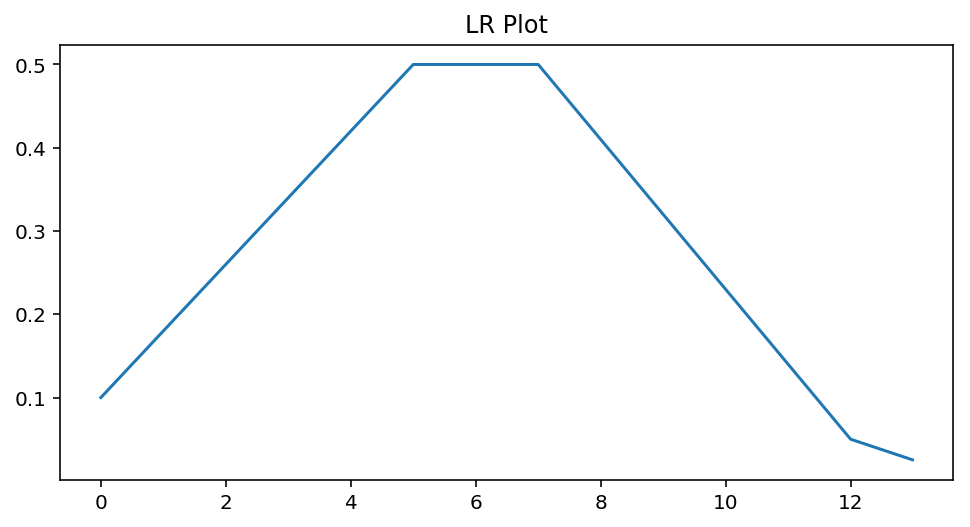

In [18]:
dx = np.arange(0,13,0.01)
dy = np.vectorize(lr_schedule)(dx)

plt.figure(figsize=(8,4))
plt.title("LR Plot")
plt.plot(dx,dy)
plt.show()

0


<Figure size 144x144 with 0 Axes>

Text(0.5, 1.0, 'dog')

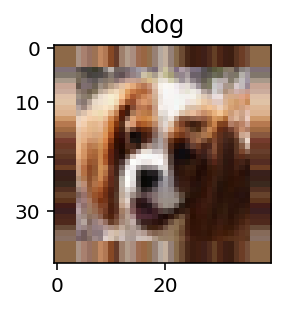

W0818 17:15:24.542507 140420598650688 deprecation.py:323] From <ipython-input-19-26c725d492d7>:26: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


Min Max =  5 249
166 3


<Figure size 144x144 with 0 Axes>

Text(0.5, 1.0, 'dog')

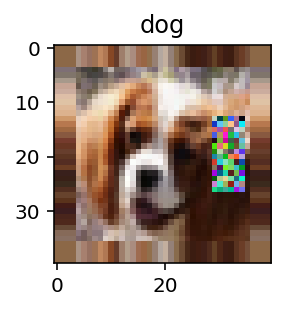

In [19]:
print(gc.collect())
exampleId = np.random.randint(0,len_train)
example = x_train[exampleId]


plt.figure(figsize=(2,2))
plt.title(classes[y_train[exampleId]])
ex = (example - np.min(example))/(np.max(example)-np.min(example))
plt.imshow(ex)
plt.show()



# example = cifar10_augs(np.array([example]))
# example = batch_cut(example,1.0,copy=True)

print("Min Max = ",np.min(example),np.max(example))
example = batch_cut(np.array([example]),1.0,copy=True)
example = cifar10_augs(example,policy_idx=6,magnitude_idx=1)




# ts = tf.data.Dataset.from_tensor_slices((example, np.array([y_train[exampleId]]))).map(data_aug1, num_parallel_calls=tf.data.experimental.AUTOTUNE).prefetch(1)
ts = tf.data.Dataset.from_tensor_slices((example, np.array([y_train[exampleId]]))).prefetch(1)
x,y = next(ts.make_one_shot_iterator())
x,y = x.numpy(),y.numpy()
example=x
print(np.max(example),np.min(example))
ex = (example - np.min(example))/(np.max(example)-np.min(example))
plt.figure(figsize=(2,2))
plt.title(classes[y_train[exampleId]])
plt.imshow(ex)
plt.show()

# Augmentation

In [21]:
print(gc.collect())
train_mean = np.mean(x_train, axis=(0,1,2))
train_std = np.std(x_train, axis=(0,1,2))
normalize = lambda x: ((x - train_mean) / train_std).astype('float32') # todo: check here   
t1 = time.time()
train_data = {}
for epoch in range(EPOCHS):
    cp = 0
    
    xt = np.copy(x_train)
#     xt = cifar10_augs(x_train)
    cp = np.interp([epoch], [0, 13], [0.75, 0.75], )[0]
    xt = batch_cut(xt, cutout_proba=cp, copy=False)
    
    
    
    train_set = tf.data.Dataset.from_tensor_slices((xt, y_train)).map(data_aug1, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(len_train).batch(len_train).prefetch(len_train)

    i = 0
    for x,y in train_set:
        assert x.numpy().shape[0]==len_train
        xt = x.numpy()
        xt = normalize(xt)
        train_set = (xt,y.numpy())
        i = i+1
    assert i==1
    
    train_data[epoch] = train_set
    
    
    if epoch%2==1:
        print("Epoch = ",epoch," Time = ",(time.time()-t1), "CP = %.2f"%(cp))
t2 = time.time()
"%.1f" %(t2-t1)


1797
Epoch =  1  Time =  20.64728331565857 CP = 0.75
Epoch =  3  Time =  41.25165295600891 CP = 0.75
Epoch =  5  Time =  61.8014931678772 CP = 0.75
Epoch =  7  Time =  82.32127094268799 CP = 0.75
Epoch =  9  Time =  102.90853500366211 CP = 0.75
Epoch =  11  Time =  123.39989829063416 CP = 0.75


'133.7'

# Persist/Read Train Set

## Persist

In [23]:
import dill as pickle
with open('train_data_s2.pkl', 'wb') as file:
    pickle.dump(train_data, file)

## Read 

In [20]:
import dill as pickle
with open('train_data_s2.pkl', 'rb') as file:
    train_data = pickle.load(file)

# Model Running / Training Loop

In [21]:
print(gc.collect())

train_accs = []
test_accs = []
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE).prefetch(len_test)
# train_set = tf.data.Dataset.from_tensor_slices(train_data[0]).batch(BATCH_SIZE).prefetch(BATCH_SIZE)

train_sets = {}
for epoch in range(EPOCHS):
    key = (epoch)%(max(train_data.keys())+1)
    train_set = train_data[key]
    train_set = tf.data.Dataset.from_tensor_slices(train_set).batch(BATCH_SIZE).prefetch(len_train)
    train_sets[epoch] = train_set


tf.keras.backend.set_learning_phase(1)    
t = time.time()
t_last = time.time()
# show_examples = list(range(EPOCHS))
show_examples = [EPOCHS-1]
for epoch in range(EPOCHS):
    train_loss = test_loss = train_acc = test_acc = 0.0
    train_set = train_sets[epoch]
    for (x, y) in train_set:
        with tf.GradientTape() as tape:
            loss, correct = model(x, y)

        var = model.trainable_variables
        grads = tape.gradient(loss, var)
        for g, v in zip(grads, var):
            g += v * (WEIGHT_DECAY/(epoch+1)) * BATCH_SIZE
        opt.apply_gradients(zip(grads, var), global_step=global_step)
        if epoch in show_examples:
            train_loss += loss.numpy()
            train_acc += correct.numpy()
    if epoch in show_examples:
        
        tf.keras.backend.set_learning_phase(0)
        for (x, y) in test_set:
            loss, correct = model(x, y)
            test_loss += loss.numpy()
            test_acc += correct.numpy()

        t2 = time.time()
        train_accs.append(train_acc / len_train)
        test_accs.append(test_acc / len_test)
        print("epoch = %2s"%epoch,'lr: %.2f' % (lr_schedule(epoch+1)), '||train=> loss: %.3f' %(train_loss / len_train), 'acc: %.3f' % (train_acc / len_train), '||val=> loss: %.3f' % (test_loss / len_test), 'val acc: %.3f' %(test_acc / len_test), '%.1fs'%(t2 - t))
    


1792
epoch = 12 lr: 0.03 ||train=> loss: 0.170 acc: 0.941 ||val=> loss: 0.265 val acc: 0.911 147.9s


In [ ]:
epoch = 12 lr: 0.03 ||train=> loss: 0.174 acc: 0.942 ||val=> loss: 0.266 val acc: 0.912 148.2s
epoch = 12 lr: 0.03 ||train=> loss: 0.168 acc: 0.943 ||val=> loss: 0.269 val acc: 0.911 150.8s